In [3]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.bgm import *
from models.sagan import *
from models.causal_model import *
from load_data import *

In [4]:
root_folder = 'dataset/celebA/'
img_dim = 64
batch_size = 128
causal_diagram = 'smiling'

if causal_diagram == 'smiling':
    saved_folder = 'saved_model/downsample_smile_lm_10_'
    cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
    num_label = len(cols)
    A = torch.zeros((num_label, num_label))
    A[0, 2:6] = 1
    A[1, 4] = 1
    
elif causal_diagram == 'attractive':
    saved_folder = 'saved_model_attractive'
    cols = ['Young', 'Male', 'Bags_Under_Eyes', 'Chubby', 'Heavy_Makeup', 'Receding_Hairline', 'Gray_Hair']
    num_label = len(cols)
    A = torch.zeros((num_label, num_label))
    A[0, 2:7] = 1
    A[1, 4] = 1
    A[1, 5] = 1
    
    
test_dataloader = get_dataloader(root_folder,'dear_test', img_dim=img_dim, 
                                    batch_size=batch_size, cols = cols)    

In [5]:
in_channels = 3
fc_size = 2048

latent_dim = 10
#latent_dim = 100
#latent_dim = 150


g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

In [6]:
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)

In [7]:
checkpoint = torch.load(f'{saved_folder}/bgm', map_location='cpu')
print(checkpoint['epoch'])

185


In [8]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [9]:
def plot_image(fake, c=10, r=None, ):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
        r = 1 if r is None else r
        _,ax = plt.subplots(r, c, figsize=(24,3*r))
        if r == 1:
            for i in range(10):
                ax[i].imshow(fake[i])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        else:
            for i in range(r):
                ax[i][0].set_ylabel(cols[i])
                for j in range(c):
                    ax[i][j].imshow(fake[i*c+j])
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    
        plt.show()

Reconstruct


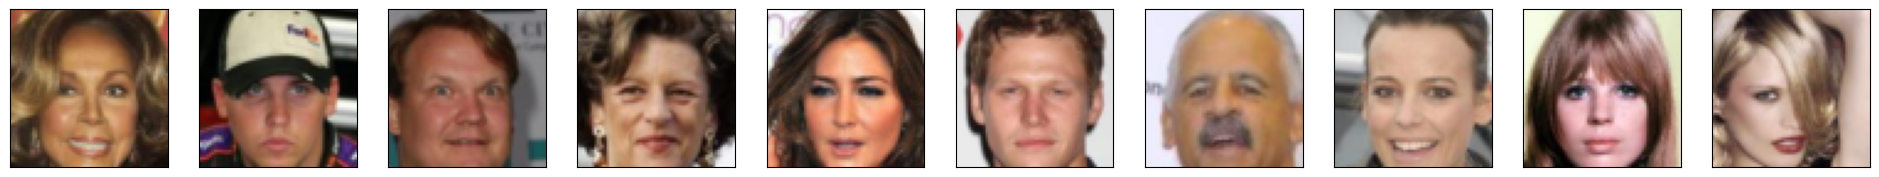

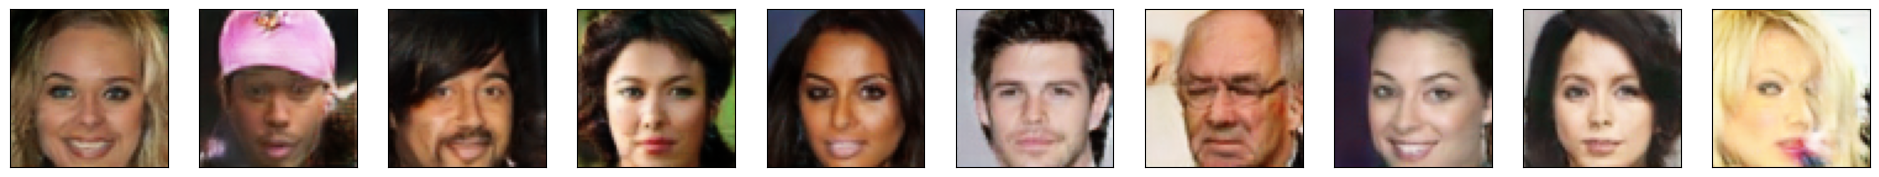

tensor([[ 31.1403,  -0.7400,  37.8922,  23.2483,  -5.6328,  -7.5939],
        [-17.7328,   6.0310,  -6.5383,  -1.1634, -18.9692,  -6.3439],
        [  4.3695,  16.2229,   3.5085,  -4.1122,  -6.3871,  -2.8983],
        [  4.1256,  -5.0298,  13.1850,  -5.8440,  -4.7379,  -3.2230],
        [  0.6502, -15.4765,  -2.1996,   4.1317,  -8.6054, -12.8149],
        [  4.0161,  -2.5670, -12.3569, -12.6889,  -1.8071,  -7.3106],
        [ -6.9833,  23.1313, -17.9118,   1.4075,   2.5823,   0.0389],
        [  5.3522,  -7.5787,   6.9790,  14.6150, -13.2777,  -9.3371],
        [ -8.8298,  -2.1945,  -2.1393, -16.4341,  -4.7419,  -7.8144],
        [  0.1376,  -3.9926, -17.4507, -13.9205,  -9.1359, -14.3281]])
tensor([[1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [1., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0.

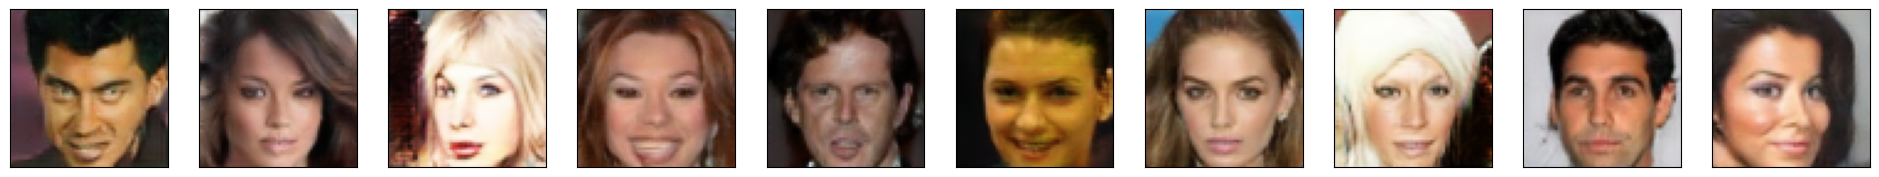

In [10]:
t = 10
for batch_idx, (x, label) in enumerate(test_dataloader):
    with torch.no_grad():
        x = x.to('cpu')
        x_ = x[:t]
        x_recon = model(x_, recon=True)
        x_recon = (x_recon * 0.5) + 0.5
        print('Reconstruct')
        plot_image(x_*0.5 + 0.5)
        plot_image(x_recon)
        feat = model.prior(model(x)[:t, :num_label])
        print(model.encode(x_)[:t, :num_label])
        print(label[:t, :])
        print(torch.round(torch.sigmoid(feat)))
        
        print('Random')
        z = torch.randn(x.size(0), latent_dim, device=x.device)
        x_fake = model(None, z)
        x_fake = x_fake * 0.5 + 0.5
        plot_image(x_fake)
        
    break

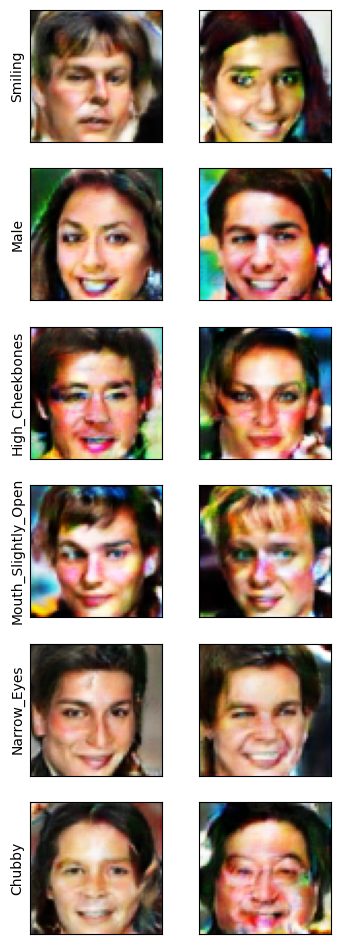

In [14]:
_, ax = plt.subplots(num_label,2, figsize=(4,12))
with torch.no_grad():
    for col_num in range(num_label):
        ax[col_num][0].set_ylabel(cols[col_num])
        eps = torch.randn(1, latent_dim, device='cpu')
        eps[:, :num_label] = torch.zeros(1, num_label, device='cpu')
        for i in range(2):   
            label_z = model.prior(eps[:, :num_label])
            label_z[:, 1] = 20
            label_z[:, col_num] = -20 if i==0 else 20
            other_z = eps[:, num_label:]
            z = torch.cat([label_z, other_z], dim=1)
            temp = model.decoder(z)
            
            temp = np.transpose(temp.numpy(), (0, 2, 3, 1))[0]
            temp = temp*0.5 + 0.5
            ax[col_num][i].imshow(temp)
            ax[col_num][i].set_xticks([])
            ax[col_num][i].set_yticks([])

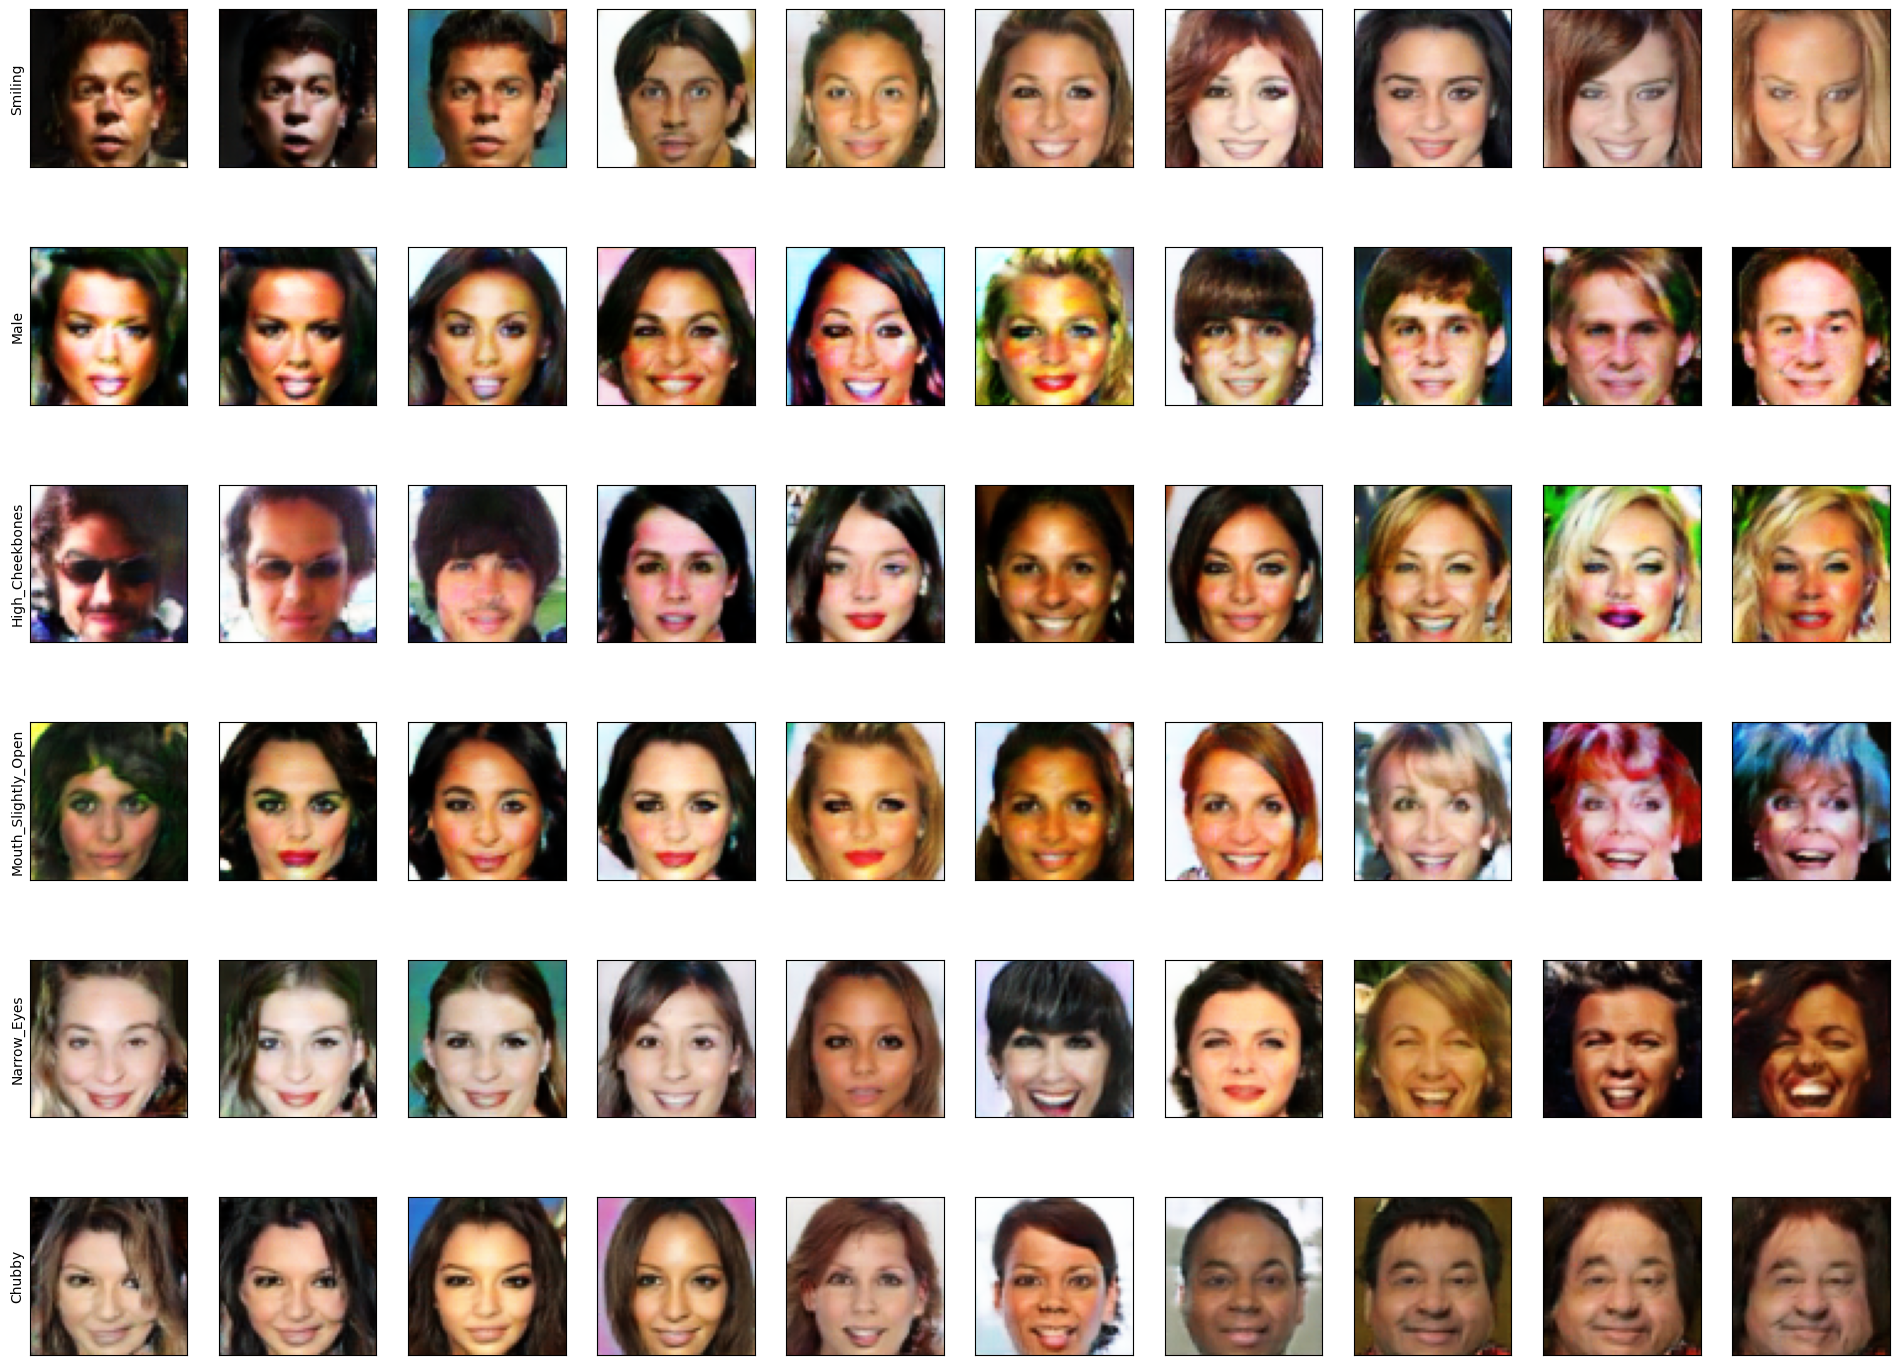

In [12]:
fixed_zeros = torch.zeros(1, latent_dim, device='cpu')
temp = model.traverse(fixed_zeros)
temp = temp * 0.5 + 0.5
plot_image(temp, r = num_label, c = 10)